In [324]:
from cassandra.cluster import Cluster
from pyspark import SparkContext
from pyspark.sql import SQLContext
import wget
from pyspark.sql import SparkSession
import os
# Configuratins related to Cassandra connector & Cluster
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.datastax.spark:spark-cassandra-connector_2.11:2.3.0 --conf spark.cassandra.connection.host=127.0.0.1 pyspark-shell'
import re
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
cluster = Cluster(['127.0.01'])
session = cluster.connect()

In [3]:
session.execute("""
    CREATE KEYSPACE IF NOT EXISTS Gdelt 
    WITH REPLICATION = 
    { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }"""
)

In [4]:
session.set_keyspace('gdelt')

In [5]:
query = "DROP TABLE masterfile"
session.execute(query)

In [6]:
query = "CREATE TABLE IF NOT EXISTS masterfile \
                                   (id int, hash text, url text, PRIMARY KEY (id))"
session.execute(query)

In [7]:
fileName = '/Users/fayyazali/Desktop/MS Big Data - Telecom Paris/NoSQL/Projet GDELT/masterfilelist.txt'
input_file = open(fileName, 'r')
lines = input_file.readlines()
input_file.close()

In [8]:
i=1
for line in lines:
    columns = line.split(' ')
    #if columns[] == "\xc2\xa0":
    #    columns[7] = ""
    if len(columns) == 3:
        columns[2] = columns[2].rstrip("\r\n")
        #print(columns)
        query = "INSERT INTO masterfile (id, hash, url)"
        query = query + " VALUES (%s, %s, %s)"
        session.execute(query, (int(columns[0]), columns[1], columns[2]))
    
    i = i+1

In [9]:
query = "CREATE CUSTOM INDEX url_idx ON gdelt.masterfile (url) USING 'org.apache.cassandra.index.sasi.SASIIndex' WITH OPTIONS = {'mode': 'CONTAINS', 'analyzer_class': 'org.apache.cassandra.index.sasi.analyzer.NonTokenizingAnalyzer', 'case_sensitive': 'false'};"
session.execute(query)

In [10]:
query = "SELECT * FROM masterfile WHERE url LIKE '%20181201%' LIMIT 20 ALLOW FILTERING;"
master_mois = session.execute(query)

In [11]:
for row in master_mois:
    wget.download(row.url, '/Users/fayyazali/Desktop/MS Big Data - Telecom Paris/NoSQL/Projet GDELT/data/')

In [12]:
#spark = SparkSession.builder.appName('demo').master("local").getOrCreate()
#masterfile_spark = spark.read.format("org.apache.spark.sql.cassandra").options(table="masterfile", keyspace="gdelt").load()
sc = SparkContext("local", "gdelt")

In [16]:
sqlContext = SQLContext(sc)

In [17]:
def load_and_get_table_df(keys_space_name, table_name):
    table_df = sqlContext.read\
        .format("org.apache.spark.sql.cassandra")\
        .options(table=table_name, keyspace=keys_space_name)\
        .load()
    return table_df

In [19]:
# Loading movies & ratings table data frames
masterfile_spark = load_and_get_table_df("gdelt", "masterfile")

In [20]:
masterfile_spark.show()

+--------+--------------------+--------------------+
|      id|                hash|                 url|
+--------+--------------------+--------------------+
| 7140530|4fb8fe4cb1874e7c9...|http://data.gdelt...|
| 6502240|1f0111ab223e99688...|http://data.gdelt...|
| 7997186|268807684f4ee6f7c...|http://data.gdelt...|
|  134087|85edbbed442dcca19...|http://data.gdelt...|
|  308686|e046df9bf237b79ef...|http://data.gdelt...|
|  363843|2f987935bb4cc6ec4...|http://data.gdelt...|
| 3573083|0a81ff4e298e1d9c9...|http://data.gdelt...|
|   28069|1ca07605afbfeb864...|http://data.gdelt...|
|   68563|93aa2f7153ce2e24a...|http://data.gdelt...|
|  319952|d6a5d9c326bbe1062...|http://data.gdelt...|
|  237266|06246011ba84b28e9...|http://data.gdelt...|
|  129095|e52b67839ee8514c4...|http://data.gdelt...|
|15994034|cdc9e1efde1fb9f84...|http://data.gdelt...|
|13944615|3b58d6d2101f6fcfb...|http://data.gdelt...|
|  149823|16e8c0f0980a5334f...|http://data.gdelt...|
|  323435|63e5da877c5769d99...|http://data.gde

In [22]:
from zipfile import ZipFile
from os import listdir
from os import remove

In [23]:
liste_zip = listdir('/Users/fayyazali/Desktop/MS Big Data - Telecom Paris/NoSQL/Projet GDELT/data/')
liste_zip = liste_zip[1:]
for file in liste_zip:
    with ZipFile('/Users/fayyazali/Desktop/MS Big Data - Telecom Paris/NoSQL/Projet GDELT/data/'+file, 'r') as zip: 
        zip.extractall('/Users/fayyazali/Desktop/MS Big Data - Telecom Paris/NoSQL/Projet GDELT/data_unzip/')
        #remove('/Users/fayyazali/Desktop/MS Big Data - Telecom Paris/NoSQL/Projet GDELT/data/'+file)

In [28]:
liste_csv = listdir('/Users/fayyazali/Desktop/MS Big Data - Telecom Paris/NoSQL/Projet GDELT/data_unzip/')
liste_csv.remove('.DS_Store')
 
liste_csv_mentions = []
liste_csv_gkg = []
liste_csv_events = [] 

for csv in liste_csv:
    if 'mentions' in csv:
        liste_csv_mentions.append(csv)
    
    if 'gkg' in csv:
        liste_csv_gkg.append(csv)
        
    if 'export' in csv:
        liste_csv_events.append(csv)

In [239]:
query = "DROP TABLE mentions"
session.execute(query)

In [240]:
query = "CREATE TABLE IF NOT EXISTS mentions \
                                   (GLOBALEVENTID int, EventTimeDate text, MentionTimeDate text, \
                                   MentionType int, MentionSourceName text, MentionIdentifier text, \
                                   SentenceID int, Actor1CharOffset int, Actor2CharOffset int, ActionCharOffset int, \
                                   InRawText int, Confidence int, MentionDocLen int, MentionDocTone float, \
                                   MentionDocTranslationInfo text, Extras text, \
                                   PRIMARY KEY (GLOBALEVENTID))"
session.execute(query)

In [241]:
for csv in liste_csv_mentions:
    input_file = open('/Users/fayyazali/Desktop/MS Big Data - Telecom Paris/NoSQL/Projet GDELT/data_unzip/'+csv, 'r')
    i = 1
    #print(i)             


    for line in input_file:
        columns = line.split('\t')
        #print(columns)
        #if columns[7] == "\xc2\xa0":
         #   columns[7] = ""
        #columns[8] = columns[8].rstrip("\r\n")
        columns[0] = int(columns[0])
        #columns[1] = int(columns[1])
        #columns[2] = int(columns[2])
        columns[3] = int(columns[3])
        columns[6] = int(columns[6])
    
        query = "INSERT INTO mentions (GLOBALEVENTID, EventTimeDate, MentionTimeDate, MentionType, MentionSourceName, \
        MentionIdentifier, SentenceID, Actor1CharOffset, Actor2CharOffset, ActionCharOffset, InRawText, \
        Confidence, MentionDocLen, MentionDocTone, MentionDocTranslationInfo, Extras)"
        query = query + " VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s )"
        session.execute(query, (columns[0], columns[1], columns[2], columns[3], 
                    columns[4], columns[5], columns[6], int(columns[7]), int(columns[8]),
                   int(columns[9]), int(columns[10]), int(columns[11]), int(columns[12]),
                        float(columns[13]), columns[14], columns[15]))
    i = i + 1

IndexError: list index out of range

In [111]:
query = "DROP TABLE gkg"
session.execute(query)

In [112]:
query = "CREATE TABLE IF NOT EXISTS gkg \
                                   (GKGRECORDID text, DATE text, SourceCollectionIdentifier int, \
                                   SourceCommonName text, DocumentIdentifier text, Counts text, \
                                   V2Counts text, Themes text, V2Themes text, Locations text, \
                                   V2Locations text, Persons text, V2Persons text, Organizations text, \
                                   V2Organizations text, V2Tone text, Dates text, GCAM text, \
                                   SharingImage text, RelatedImages text, SocialImageEmbeds text,  \
                                   SocialVideoEmbeds text, Quotations text, AllNames text, Amounts text, \
                                   TranslationInfo text, Extras text, \
                                   PRIMARY KEY (GKGRECORDID))"
session.execute(query)

In [116]:
for csv in liste_csv_gkg:
    input_file = open('/Users/fayyazali/Desktop/MS Big Data - Telecom Paris/NoSQL/Projet GDELT/data_unzip/'+csv, 'r',encoding="utf8", errors='ignore')
    i = 1
    #print(i)             


    for line in input_file:
        columns = line.split('\t')
        #columns = ';'.join(map(str,columns))
        #columns = columns.split(";")
        #print(len(columns))
        #if columns[7] == "\xc2\xa0":
         #   columns[7] = ""
        #columns[8] = columns[8].rstrip("\r\n")
       
    
        query = "INSERT INTO gkg (GKGRECORDID, DATE, SourceCollectionIdentifier, \
                                   SourceCommonName, DocumentIdentifier, Counts, \
                                   V2Counts, Themes, V2Themes, Locations, \
                                   V2Locations, Persons, V2Persons, Organizations, \
                                   V2Organizations, V2Togkgne, Dates, GCAM, \
                                   SharingImage, RelatedImages, SocialImageEmbeds,  \
                                   SocialVideoEmbeds, Quotations, AllNames, Amounts, \
                                   TranslationInfo, Extras)"
        query = query + " VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, \
        %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
        session.execute(query, (columns[0], columns[1], int(columns[2]), columns[3], 
                    columns[4], columns[5], columns[6], columns[7], columns[8],
                   columns[9], columns[10], columns[11], columns[12],
                        columns[13], columns[14], columns[15], columns[16] , columns[17]
                               , columns[18], columns[19], columns[20], columns[21]
                               , columns[22], columns[23], columns[24], columns[25], columns[26]))
        i = i + 1

In [206]:
query = "DROP TABLE events"
session.execute(query)

In [207]:
query = "CREATE TABLE IF NOT EXISTS events \
                                   (GLOBALEVENTID int, SQLDATE int, MonthYear int, \
                                   Year int, FractionDate text, Actor1Code text, \
                                   Actor1Name text, Actor1CountryCode text, Actor1KnownGroupCode text, Actor1EthnicCode text, \
                                   Actor1Religion1Code text, Actor1Religion2Code text, Actor1Type1Code text, \
                                   Actor1Type2Code text, Actor1Type3Code text, Actor2Code text , \
                                   Actor2Name text, Actor2CountryCode text, Actor2KnownGroupCode text, Actor2EthnicCode text, \
                                   Actor2Religion1Code text, Actor2Religion2Code text, Actor2Type1Code text, \
                                   Actor2Type2Code text, Actor2Type3Code text, IsRootEvent text, EventCode text, \
                                   EventBaseCode text, EventRootCode text, QuadClass text, GoldsteinScale text, \
                                   NumMentions text, NumSources text, NumArticles text, AvgTone text, Actor1Geo_Type text, \
                                   Actor1Geo_FullName text, Actor1Geo_CountryCode text, Actor1Geo_ADM1Code text, \
                                   Actor1Geo_ADM2Code text, Actor1Geo_Lat text, Actor1Geo_Long text, Actor1Geo_FeatureID text, \
                                   Actor2Geo_Type text, Actor2Geo_FullName text, Actor2Geo_CountryCode text, \
                                   Actor2Geo_ADM1Code text, Actor2Geo_ADM2Code text, Actor2Geo_Lat text, \
                                   Actor2Geo_Long text, Actor2Geo_FeatureID text, ActionGeo_Type text, ActionGeo_FullName text, \
                                   ActionGeo_CountryCode text, ActionGeo_ADM1Code text, ActionGeo_ADM2Code text, ActionGeo_Lat text, \
                                   ActionGeo_Long text, ActionGeo_FeatureID text, DATEADDED text, SOURCEURL text,  \
                                   PRIMARY KEY (GLOBALEVENTID))"
session.execute(query)

In [208]:
for csv in liste_csv_events:
    input_file = open('/Users/fayyazali/Desktop/MS Big Data - Telecom Paris/NoSQL/Projet GDELT/data_unzip/'+csv, 'r',encoding="utf8", errors='ignore')
    i = 1
    #print(i)             


    for line in input_file:
        columns = line.split('\t')
  
        columns[0] = int(columns[0])
        columns[1] = int(columns[1])
        columns[2] = int(columns[2])
        columns[3] = int(columns[3])
    
        query = "INSERT INTO events (GLOBALEVENTID, SQLDATE, MonthYear, \
                                   Year, FractionDate, Actor1Code, \
                                   Actor1Name, Actor1CountryCode, Actor1KnownGroupCode, Actor1EthnicCode, \
                                   Actor1Religion1Code, Actor1Religion2Code, Actor1Type1Code, \
                                   Actor1Type2Code, Actor1Type3Code, Actor2Code, \
                                   Actor2Name, Actor2CountryCode, Actor2KnownGroupCode, Actor2EthnicCode, \
                                   Actor2Religion1Code, Actor2Religion2Code, Actor2Type1Code, \
                                   Actor2Type2Code, Actor2Type3Code, IsRootEvent, EventCode, \
                                   EventBaseCode, EventRootCode, QuadClass, GoldsteinScale, \
                                   NumMentions, NumSources, NumArticles, AvgTone, Actor1Geo_Type, \
                                   Actor1Geo_FullName, Actor1Geo_CountryCode, Actor1Geo_ADM1Code, \
                                   Actor1Geo_ADM2Code, Actor1Geo_Lat, Actor1Geo_Long, Actor1Geo_FeatureID, \
                                   Actor2Geo_Type, Actor2Geo_FullName, Actor2Geo_CountryCode, \
                                   Actor2Geo_ADM1Code, Actor2Geo_ADM2Code, Actor2Geo_Lat, \
                                   Actor2Geo_Long, Actor2Geo_FeatureID, ActionGeo_Type, ActionGeo_FullName, \
                                   ActionGeo_CountryCode, ActionGeo_ADM1Code, ActionGeo_ADM2Code, ActionGeo_Lat, \
                                   ActionGeo_Long, ActionGeo_FeatureID, DATEADDED, SOURCEURL)"
        query = query + " VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, \
        %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, \
        %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, \
        %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, \
        %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, \
        %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, \
        %s)"
        session.execute(query,(columns))
        i = i + 1

In [242]:
events_spark = load_and_get_table_df("gdelt", "events")
gkg_spark = load_and_get_table_df("gdelt", "gkg")
mentions_spark = load_and_get_table_df("gdelt", "mentions")

# afficher le nombre d’articles/évènements qu’il y a eu pour chaque triplet (jour, pays de l’évènement, langue de l’article).

In [218]:
mentions_spark.groupby("SQLDATE").count().show()

+--------+-----+
| SQLDATE|count|
+--------+-----+
|20181124|   50|
|20181130|   27|
|20181101|   54|
|20171201|   74|
|20181201| 8411|
+--------+-----+



In [224]:
#events_spark.select('GLOBALEVENTID').show()
events_spark.groupby("SQLDATE","ActionGeo_CountryCode",).count().show()

+--------+---------------------+-----+
| SQLDATE|ActionGeo_CountryCode|count|
+--------+---------------------+-----+
|20181201|                   OS|    6|
|20171201|                   VM|    7|
|20181130|                   US|    3|
|20181201|                   RQ|    2|
|20181201|                   MY|   79|
|20181201|                   BH|    8|
|20181201|                   BT|    4|
|20181201|                   BO|    3|
|20181201|                   VC|    1|
|20181130|                   NP|    6|
|20181201|                   LY|    1|
|20181201|                   MP|    3|
|20181101|                   CI|    2|
|20181201|                   TH|   15|
|20181201|                   GT|    9|
|20181201|                   AY|    1|
|20181201|                   TZ|    6|
|20181201|                   IS|  140|
|20181201|                   SN|   21|
|20171201|                   RS|    8|
+--------+---------------------+-----+
only showing top 20 rows



In [222]:
mentions_spark.groupby('MentionDocTranslationInfo').count().show()

+-------------------------+-----+
|MentionDocTranslationInfo|count|
+-------------------------+-----+
|                         |25451|
+-------------------------+-----+



In [307]:
from pyspark.sql.functions import udf
suff = udf(lambda x: '.'.join(map(str,x.split('.')[1:])))
langue_eng = udf(lambda x: 'eng' if x=='' else x)
langue = udf(lambda x: 'eng' if x =='' else x.split(':')[1].split(';')[0])

In [296]:
x='srclc:rus;eng:GT-RUS 1.0'
x.split(':')[1].split(';')[0]

'rus'

In [246]:
mentions_spark = mentions_spark.withColumn("Suffixe",suff(mentions_spark["MentionSourceName"]))
mentions_spark.select('Suffixe').show() 

+-------+
|Suffixe|
+-------+
|    com|
|    com|
|    com|
|    com|
|    com|
|    com|
|    com|
|    com|
|    com|
|    com|
|    com|
|    com|
|    net|
|    com|
|     tw|
|    com|
|     in|
|    com|
|  co.uk|
|    com|
+-------+
only showing top 20 rows



In [309]:
mentions_spark = mentions_spark.withColumn("langue",langue(mentions_spark["MentionDocTranslationInfo"]))
mentions_spark.select('langue').show()

+------+
|langue|
+------+
|   eng|
|   eng|
|   eng|
|   eng|
|   eng|
|   eng|
|   eng|
|   eng|
|   eng|
|   eng|
|   eng|
|   eng|
|   eng|
|   eng|
|   eng|
|   eng|
|   eng|
|   eng|
|   eng|
|   eng|
+------+
only showing top 20 rows



In [313]:
jme = events_spark.join(mentions_spark, events_spark["GLOBALEVENTID"] == mentions_spark["GLOBALEVENTID"])

In [315]:
jme.groupby("SQLDATE","ActionGeo_CountryCode","Suffixe").count().sort('count', ascending=False).show()

+--------+---------------------+-------+-----+
| SQLDATE|ActionGeo_CountryCode|Suffixe|count|
+--------+---------------------+-------+-----+
|20181201|                   US|    com|  142|
|20181201|                   CH|    com|   22|
|20181201|                   AS| com.au|   21|
|20181201|                   IN|    com|   19|
|20181201|                   FR|    com|   17|
|20181201|                   AJ|     am|   16|
|20181201|                   NI|    com|   14|
|20181201|                   RS|    com|   14|
|20181201|                   AR|    com|   13|
|20181201|                   SA|    com|   13|
|20181201|                   SY|    com|   12|
|20181201|                   IS|    com|   10|
|20181201|                     |    com|    9|
|20181201|                   KN|    com|    8|
|20181201|                   CA|    com|    6|
|20181201|                   UK|    com|    6|
|20181201|                   YM|    com|    5|
|20181201|                   KU|    com|    5|
|20181201|   

In [316]:
jme.groupby("SQLDATE","ActionGeo_CountryCode","langue").count().sort('count', ascending=False).show()

+--------+---------------------+------+-----+
| SQLDATE|ActionGeo_CountryCode|langue|count|
+--------+---------------------+------+-----+
|20181201|                   US|   eng|  154|
|20181201|                   FR|   eng|   26|
|20181201|                   CH|   eng|   22|
|20181201|                   AS|   eng|   22|
|20181201|                   NI|   eng|   20|
|20181201|                   IN|   eng|   19|
|20181201|                   RS|   eng|   18|
|20181201|                   AR|   eng|   16|
|20181201|                   AJ|   eng|   16|
|20181201|                     |   eng|   15|
|20181201|                   SA|   eng|   14|
|20181201|                   SY|   eng|   13|
|20181201|                   IS|   eng|   10|
|20181201|                   KN|   eng|    9|
|20181201|                   UK|   eng|    8|
|20181201|                   KU|   eng|    8|
|20181201|                   JA|   eng|    7|
|20181201|                   CA|   eng|    7|
|20181201|                   MY|  

In [353]:
df = jme.groupby("SQLDATE","ActionGeo_CountryCode","Suffixe").count().limit(50).sort('count', ascending=False)
df.show()

+--------+---------------------+-------+-----+
| SQLDATE|ActionGeo_CountryCode|Suffixe|count|
+--------+---------------------+-------+-----+
|20181201|                   AS| com.au|   21|
|20181201|                   IN|    com|   19|
|20181201|                   AJ|     am|   16|
|20181201|                   RS|    com|   14|
|20181201|                   AR|    com|   13|
|20181201|                   SY|    com|   12|
|20181201|                   IS|    com|   10|
|20181201|                     |    com|    9|
|20181201|                   CA|    com|    6|
|20181201|                   UK|    com|    6|
|20181201|                   YM|    com|    5|
|20181201|                   NI|     ng|    4|
|20181201|                   MU|  co.uk|    4|
|20181201|                   JA|    org|    4|
|20181201|                   KU|  co.uk|    3|
|20181201|                   KS|  co.nz|    3|
|20181201|                   NZ|  pe.ca|    2|
|20181201|                   AM|     am|    2|
|20181201|   

In [347]:
df_pandas = df.toPandas()

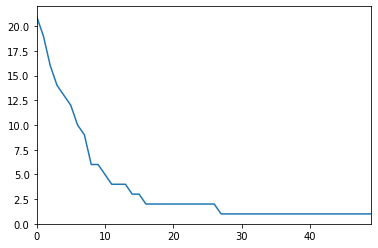

In [354]:
df_pandas['count'].plot()

# pour un pays donné en paramètre, affichez les évènements qui y ont eu place triées par le nombre de mentions (tri décroissant); permettez une agrégation par jour/mois/année

# pour une source de donnés passée en paramètre (gkg.SourceCommonName) affichez les thèmes, personnes, lieux dont les articles de cette sources parlent ainsi que le le nombre d’articles et le ton moyen des articles (pour chaque thème/personne/lieu); permettez une agrégation par jour/mois/année.

# dresser la cartographie des relations entre les pays d’après le ton des articles : pour chaque paire (pays1, pays2), calculer le nombre d’article, le ton moyen (aggrégations sur Année/Mois/Jour, filtrage par pays ou carré de coordonnées)